In [57]:
import os

os.chdir(r"D:\\AML project")

In [58]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
import nltk


from sentence_transformers import SentenceTransformer



### Import the Data

In [59]:
# Load the first CSV file (Books_rating) into a pandas DataFrame
# books_rating_df = pd.read_csv('archive\\Books_rating.csv')

# Load the second CSV file (Books_data) into a pandas DataFrame
amazon_books = pd.read_csv('archive\\books_data.csv')

### preprocess the data

In [60]:
amazon_books.shape

(212404, 10)

In [61]:
amazon_books.head()

Title  \
0                     Its Only Art If Its Well Hung!   
1                           Dr. Seuss: American Icon   
2              Wonderful Worship in Smaller Churches   
3                      Whispers of the Wicked Saints   
4  Nation Dance: Religion, Identity and Cultural ...   

                                         description              authors  \
0                                                NaN     ['Julie Strain']   
1  Philip Nel takes a fascinating look into the k...       ['Philip Nel']   
2  This resource includes twelve principles in un...     ['David R. Ray']   
3  Julia Thomas finds her life spinning out of co...  ['Veronica Haddon']   
4                                                NaN      ['Edward Long']   

                                               image  \
0  http://books.google.com/books/content?id=DykPA...   
1  http://books.google.com/books/content?id=IjvHQ...   
2  http://books.google.com/books/content?id=2tsDA...   
3  http://books.google.com/books/content?id=aRSIg...   
4                                                NaN   

                                         previewLink  publisher publishedDate  \
0  http://books.google.nl/books?id=DykPAAAACAAJ&d...        NaN          1996   
1  http://books.google.nl/books?id=IjvHQsCn_pgC&p...  A&C Black    2005-01-01   
2  http://books.google.nl/books?id=2tsDAAAACAAJ&d...        NaN          2000   
3  http://books.google.nl/books?id=aRSIgJlq6JwC&d...  iUniverse       2005-02   
4  http://books.google.nl/books?id=399SPgAACAAJ&d...        NaN    2003-03-01   

                                            infoLink  \
0  http://books.google.nl/books?id=DykPAAAACAAJ&d...   
1  http://books.google.nl/books?id=IjvHQsCn_pgC&d...   
2  http://books.google.nl/books?id=2tsDAAAACAAJ&d...   
3  http://books.google.nl/books?id=aRSIgJlq6JwC&d...   
4  http://books.google.nl/books?id=399SPgAACAAJ&d...   

                      categories  ratingsCount  
0    ['Comics & Graphic Novels']           NaN  
1  ['Biography & Autobiography']           NaN  
2                   ['Religion']           NaN  
3                    ['Fiction']           NaN  
4                            NaN           NaN

##### Checking for duplicates & dropping

In [62]:
duplicate_rows = amazon_books.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

Number of duplicate rows: 0


In [63]:
amazon_books.drop_duplicates(inplace=True)

#### Checking for missing values and dropping them

In [64]:
missing_values = amazon_books.isnull().sum()
print("Number of missing values:")
print(missing_values)

Number of missing values:
Title                 1
description       68442
authors           31413
image             52075
previewLink       23836
publisher         75886
publishedDate     25305
infoLink          23836
categories        41199
ratingsCount     162652
dtype: int64


In [65]:
# Assuming your DataFrame is named amazon_books
amazon_books.dropna(inplace=True)

In [66]:
amazon_books.shape

(40635, 10)

#### Checking the number of unique books

In [67]:
# Assuming 'title' is the column containing the unique identifier for books
num_unique_books = amazon_books['Title'].nunique()

print("Number of unique books:", num_unique_books)

Number of unique books: 40635


#### Dropping unecessary columns and changing the column title to lowercase

In [68]:
# Convert 'Title' column to lowercase
amazon_books['title'] = amazon_books['Title'].str.lower()

# Drop columns 'image', 'publisher', 'publishedDate', 'infoLink', 'ratingsCount'
columns_to_drop = ['image', 'publisher', 'publishedDate', 'infoLink', 'ratingsCount', 'Title', 'previewLink']
amazon_books.drop(columns=columns_to_drop, inplace=True)


In [69]:
# Dropping the index
amazon_books.reset_index(drop=True, inplace=True)
print(amazon_books.shape)
amazon_books.head()

(40635, 4)


description                  authors  \
0  In The Church of Christ: A Biblical Ecclesiolo...     ['Everett Ferguson']   
1  Twenty-five years ago, at the height of the co...          ['Rupert Fike']   
2  The Bismarck is perhaps the most famous – and ...     ['Stefan Draminski']   
3  In 1543, on a windswept isle off of Scotland, ...       ['May Mcgoldrick']   
4  "Beginner's Yoruba" is now available with two ...  ['Kayode J. Fakinlede']   

                      categories  \
0                   ['Religion']   
1  ['Biography & Autobiography']   
2                    ['History']   
3           ['Juvenile Fiction']   
4     ['Foreign Language Study']   

                                               title  
0  the church of christ: a biblical ecclesiology ...  
1  voices from the farm: adventures in community ...  
2                            the battleship bismarck  
3                            tess and the highlander  
4   beginner's yoruba (hippocrene beginner's series)

#### Preprocessing the text columns - removing punctation, converting to lowercase, removing extra white space

In [70]:
import re

def preprocess_text(text):
    # Remove extra white spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Convert text to lowercase
    text = text.lower()

    # Remove the string "a novel" without replacing it with a white space
    text = re.sub(r'\ba novel\b', '', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove extra white spaces again
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

# Apply the preprocessing function to text columns
text_columns = ['authors', 'categories', 'title']
for column in text_columns:
    amazon_books[column] = amazon_books[column].apply(preprocess_text)


In [71]:
def preprocess_desc(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation and special characters
    #text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Optionally, remove numbers (commented out for testing)
    # text = re.sub(r'\d+', '', text)
    
    return text

# Apply the preprocessing function to text columns
text_columns = ['description']
for column in text_columns:
    amazon_books[column] = amazon_books[column].apply(preprocess_text)

In [72]:
amazon_books.head()

description             authors  \
0  in the church of christ a biblical ecclesiolog...    everett ferguson   
1  twentyfive years ago at the height of the coun...         rupert fike   
2  the bismarck is perhaps the most famous and no...    stefan draminski   
3  in 1543 on a windswept isle off of scotland se...      may mcgoldrick   
4  beginners yoruba is now available with two acc...  kayode j fakinlede   

                categories                                              title  
0                 religion  the church of christ a biblical ecclesiology f...  
1  biography autobiography  voices from the farm adventures in community l...  
2                  history                            the battleship bismarck  
3         juvenile fiction                            tess and the highlander  
4   foreign language study       beginners yoruba hippocrene beginners series

In [73]:
amazon_books['description'][300]

'describes basic techniques for determining the optical constants of crystals using only a polarizing microscope and immersion media for beginning students in optical crystallography'

#### Checking the unique values in each column for data integrity

In [74]:
columns_to_check = ['description', 'authors', 'categories', 'title']


# Calculate the number of unique values for each column
unique_value_counts = {col: len(amazon_books[col].unique()) for col in columns_to_check}

print(amazon_books.shape)

# Print the results
for col, count in unique_value_counts.items():
    print(f"Column '{col}' has {count} unique values.")

(40635, 4)
Column 'description' has 36591 unique values.
Column 'authors' has 26736 unique values.
Column 'categories' has 1067 unique values.
Column 'title' has 39369 unique values.


-> Same book title can have multiple description, beacuse they can have multiple authors & there can be one description for multiple book titles as there can be different volumes or editions.

-> Multiple Titles for the Same Book: There could be cases where the same book has multiple titles (e.g., different editions, translations, or versions), resulting in multiple titles but a single book ID.

-> Generating a book_id which check for unique combination of title and author.

#### Generating book_id

In [75]:
'''
# Concatenate title and authors columns to create a unique identifier
amazon_books['unique_identifier'] = amazon_books['title'] + '_' + amazon_books['authors']

# Create a new DataFrame with only the unique identifiers
unique_books_df = amazon_books[['unique_identifier']].drop_duplicates()

# Generate book IDs
unique_books_df['book_id'] = ['A' + str(index + 1) for index in range(len(unique_books_df))]

# Merge the generated book IDs back into the original DataFrame based on the unique identifier
amazon_books = pd.merge(amazon_books, unique_books_df, on='unique_identifier', how='inner')

# Drop the temporary unique identifier column
amazon_books.drop(columns=['unique_identifier'], inplace=True)
'''

"\n# Concatenate title and authors columns to create a unique identifier\namazon_books['unique_identifier'] = amazon_books['title'] + '_' + amazon_books['authors']\n\n# Create a new DataFrame with only the unique identifiers\nunique_books_df = amazon_books[['unique_identifier']].drop_duplicates()\n\n# Generate book IDs\nunique_books_df['book_id'] = ['A' + str(index + 1) for index in range(len(unique_books_df))]\n\n# Merge the generated book IDs back into the original DataFrame based on the unique identifier\namazon_books = pd.merge(amazon_books, unique_books_df, on='unique_identifier', how='inner')\n\n# Drop the temporary unique identifier column\namazon_books.drop(columns=['unique_identifier'], inplace=True)\n"

In [76]:
amazon_books.head()

description             authors  \
0  in the church of christ a biblical ecclesiolog...    everett ferguson   
1  twentyfive years ago at the height of the coun...         rupert fike   
2  the bismarck is perhaps the most famous and no...    stefan draminski   
3  in 1543 on a windswept isle off of scotland se...      may mcgoldrick   
4  beginners yoruba is now available with two acc...  kayode j fakinlede   

                categories                                              title  
0                 religion  the church of christ a biblical ecclesiology f...  
1  biography autobiography  voices from the farm adventures in community l...  
2                  history                            the battleship bismarck  
3         juvenile fiction                            tess and the highlander  
4   foreign language study       beginners yoruba hippocrene beginners series

In [77]:
columns_to_check = ['description', 'authors', 'categories', 'title']


# Calculate the number of unique values for each column
unique_value_counts = {col: len(amazon_books[col].unique()) for col in columns_to_check}

print(amazon_books.shape)

# Print the results
for col, count in unique_value_counts.items():
    print(f"Column '{col}' has {count} unique values.")

(40635, 4)
Column 'description' has 36591 unique values.
Column 'authors' has 26736 unique values.
Column 'categories' has 1067 unique values.
Column 'title' has 39369 unique values.


In [78]:
# Check for cases where multiple books have the same description
duplicated_descriptions = amazon_books[amazon_books.duplicated(subset='description', keep=False)]
print("Number of duplicated descriptions:", len(duplicated_descriptions))


Number of duplicated descriptions: 7230


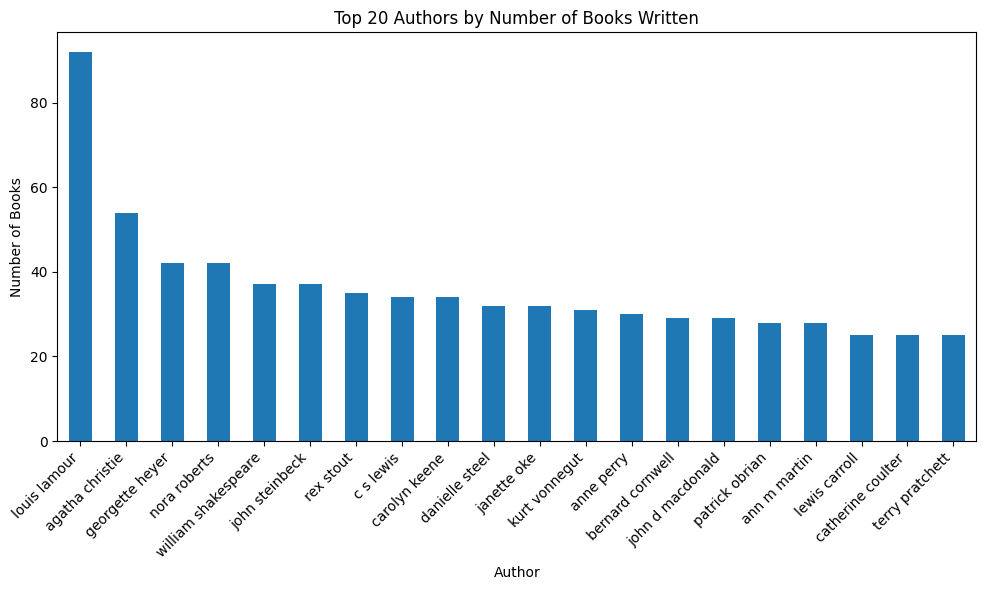

In [79]:
# Splitting the authors column into individual authors
authors_split = amazon_books['authors'].str.split(', ')

# Flattening the list of authors
all_authors = [author for sublist in authors_split.dropna() for author in sublist]

# Counting the number of books written by each author
author_counts = pd.Series(all_authors).value_counts()

# Plotting the bar plot
plt.figure(figsize=(10, 6))
author_counts.head(20).plot(kind='bar')
plt.title('Top 20 Authors by Number of Books Written')
plt.xlabel('Author')
plt.ylabel('Number of Books')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [80]:
# Get the number of rows before dropping duplicates
num_rows_before = len(amazon_books)

# Drop redundant entries based on title, author, and description
amazon_books.drop_duplicates(subset=['title', 'authors', 'description'], inplace=True)

# Get the number of rows after dropping duplicates
num_rows_after = len(amazon_books)

# Calculate the number of dropped entries
num_dropped_entries = num_rows_before - num_rows_after

print("Number of dropped entries:", num_dropped_entries)


Number of dropped entries: 1139


In [81]:
columns_to_check = ['description', 'authors', 'categories', 'title']

# Load your dataset (if not already loaded)
# amazon_books = pd.read_csv('your_dataset.csv')

# Calculate the number of unique values for each column
unique_value_counts = {col: len(amazon_books[col].unique()) for col in columns_to_check}

print(amazon_books.shape)

# Print the results
for col, count in unique_value_counts.items():
    print(f"Column '{col}' has {count} unique values.")

(39496, 4)
Column 'description' has 36591 unique values.
Column 'authors' has 26736 unique values.
Column 'categories' has 1067 unique values.
Column 'title' has 39369 unique values.


#### Filtering out books, based on authors who have more than 2 publications

In [82]:
# Count the number of books published by each author
author_counts = amazon_books['authors'].value_counts()

# Filter out authors who have published more than 2 books
prolific_authors = author_counts[author_counts >= 2].index.tolist()

# Filter the DataFrame to retain only books by these authors
filtered_amazon_books = amazon_books[amazon_books['authors'].isin(prolific_authors)]


In [83]:
# Convert it to DataFrame (although it's not necessary)
filtered_amazon_books = pd.DataFrame(filtered_amazon_books)

In [84]:
# Concatenate title and authors columns to create a unique identifier
filtered_amazon_books['unique_identifier'] = filtered_amazon_books['title'] + '_' + filtered_amazon_books['authors']

# Create a new DataFrame with only the unique identifiers
unique_books_df = filtered_amazon_books[['unique_identifier']].drop_duplicates()

# Generate book IDs
unique_books_df['book_id'] = ['A' + str(index + 1) for index in range(len(unique_books_df))]

# Merge the generated book IDs back into the original DataFrame based on the unique identifier
filtered_amazon_books = pd.merge(filtered_amazon_books, unique_books_df, on='unique_identifier', how='inner')

# Drop the temporary unique identifier column
filtered_amazon_books.drop(columns=['unique_identifier'], inplace=True)


In [85]:
# Find rows with duplicate book_id values
duplicate_rows = filtered_amazon_books[filtered_amazon_books.duplicated(subset=['book_id'], keep=False)]

# Display the duplicate rows
print("Duplicate rows based on 'book_id':")
print(duplicate_rows)

Duplicate rows based on 'book_id':
                                             description              authors  \
43     a matchmaker finds love for a wouldbe rabbi a ...      bernard malamud   
66     the greengage summer is rumer goddens tense ev...         rumer godden   
164    recounts the story of the 1820 wreck of the wh...  nathaniel philbrick   
197    the very literal minded amelia bedelia becomes...         peggy parish   
227    till we have faces is a retelling of a story a...            c s lewis   
...                                                  ...                  ...   
16652  documents the lives of missionaries who sought...     elisabeth elliot   
16866  a collectible 50th anniversary deluxe edition ...       john steinbeck   
17027  dick young is lent a house in cornwall by his ...    daphne du maurier   
17637  from the author of mayflower valiant ambition ...  nathaniel philbrick   
18051  drawing on such unique sources as thornton wil...      thornton wil

In [86]:
# Drop duplicate rows based on 'book_id' column
filtered_amazon_books.drop_duplicates(subset=['book_id'], inplace=True)

# Reset the index after dropping duplicates
filtered_amazon_books.reset_index(drop=True, inplace=True)

# Check if the indices are intact after resetting
if np.array_equal(filtered_amazon_books.index.values, np.arange(len(filtered_amazon_books))):
    print("Indices have been reset and are now intact after dropping duplicates.")
else:
    print("Some indices are still missing or out of order after dropping duplicates and resetting.")


Indices have been reset and are now intact after dropping duplicates.


In [87]:
filtered_amazon_books.shape

(18194, 5)

In [88]:
filtered_amazon_books['title'].nunique()

18175

In [89]:
# Get the index of the DataFrame
actual_indices = filtered_amazon_books.index.values

# Generate the range of expected indices
expected_indices = np.arange(len(filtered_amazon_books))

# Check if the actual indices match the expected indices
if np.array_equal(actual_indices, expected_indices):
    print("All indices are intact.")
else:
    print("Some indices are missing or out of order.")


All indices are intact.


In [90]:
# Reset the index of the DataFrame
filtered_amazon_books.reset_index(drop=True, inplace=True)

# Check if the indices are now intact
if np.array_equal(filtered_amazon_books.index.values, np.arange(len(filtered_amazon_books))):
    print("Indices have been reset and are now intact.")
else:
    print("Some indices are still missing or out of order after resetting.")


Indices have been reset and are now intact.


In [91]:
filtered_amazon_books.head()

description           authors  \
0  the bismarck is perhaps the most famous and no...  stefan draminski   
1  in 1543 on a windswept isle off of scotland se...    may mcgoldrick   
2  for centuries postandbeam construction has pro...       tedd benson   
3  this beautifully illustrated fullcolor book ex...      tom williams   
4  theres something strange about the new girls i...          lj smith   

         categories                                              title book_id  
0           history                            the battleship bismarck      A1  
1  juvenile fiction                            tess and the highlander      A2  
2      architecture  building the timber frame house the revival of...      A3  
3    health fitness  the complete illustrated guide to chinese medi...      A4  
4  juvenile fiction                  night world daughters of darkness      A5

### Banned_books

In [92]:
banned_books = pd.read_csv("archive\\full_output.csv")

In [93]:
banned_books.head()

Unnamed: 0                                              Title  \
0           0  Liar, Temptress, Soldier, Spy: Four Women Unde...   
1           1                                      Ace of Spades   
2           2                                         The Poet X   
3           3       Uncomfortable Conversations with a Black Boy   
4           4                               Half of a Yellow Sun   

                      Author                 Key  Publish  \
0              Abbott, Karen  /works/OL21102574W   2014.0   
1     Àbíké-Íyímídé, Faridah  /works/OL24592776W   2019.0   
2         Acevedo, Elizabeth  /works/OL19734273W   2018.0   
3             Acho, Emmanuel  /works/OL24522195W   2021.0   
4  Adichie, Chimamanda Ngozi   /works/OL5731542W   2006.0   

                                             Subject  \
0  ['Spies', 'United states, history, civil war, ...   
1  ['nyt:young-adult-hardcover=2021-06-20', 'New ...   
2  ['Poets', 'Schools', 'Self-esteem', 'Adolescen...   
3  ['nyt:childrens-middle-grade-hardcover=2021-05...   
4  ['literary fiction', 'historical fiction', 'po...   

                                         Description  
0                          No description available.  
1  {'type': '/type/text', 'value': 'Ace of Spades...  
2  Xiomara Batista feels unheard and unable to hi...  
3                          No description available.  
4  Half of a Yellow Sun is a novel by Nigerian au...

In [94]:
banned_books.shape

(2162, 7)

In [95]:
banned_books.drop(["Unnamed: 0", "Key", "Publish"], axis=1, inplace=True)

In [96]:
#banned_books.drop(["Index"], axis=1, inplace=True)

In [97]:
import re

# Function to Author names
def clean_text(text):
    # Remove commas from author names
    cleaned_text = text.replace(",", "")
    # Remove regular expressions from book titles
    cleaned_text = re.sub(r'\[.*?\]', '', cleaned_text)
    # Convert to lowercase
    cleaned_text = cleaned_text.lower()
    return cleaned_text

# Function to clean subjects
def clean_subjects(subjects):
    # Remove date-like patterns (e.g., hardcover=2021-06-20)
    cleaned_subjects = re.sub(r'\b\w+=\d{4}-\d{2}-\d{2}\b', '', subjects)
    # Remove "nyt:" if present
    cleaned_subjects = cleaned_subjects.replace("nyt:", "")
    # Remove quotes and brackets
    cleaned_subjects = re.sub(r'\'|\[|\]|\--|\,', '', cleaned_subjects)
    # Remove colons and -, replace with space
    cleaned_subjects = re.sub(r'\:|\-', ' ', cleaned_subjects)
    # Remove / and replace with ,
    cleaned_subjects = re.sub(r'\/', ',', cleaned_subjects)
    # Convert to lowercase
    cleaned_subjects = cleaned_subjects.lower()
    return cleaned_subjects

def clean_title(title):
    cleaned_title = re.sub(r'[^\w\s]', '', title)  # Remove all symbols except for whitespace and word characters
    return cleaned_title.strip().lower()  # Remove leading and trailing whitespace

def clean_description(description):
    # Check if description is NaN
    if pd.isna(description):
        return description
    
    # Remove '{', '}', single quotes, double quotes, hyphens, square brackets,
    # parentheses, caret, ampersand, asterisk, hash, dollar, percent, at sign, exclamation mark
    cleaned_description = re.sub(r"[{}\"[\]\(\)\]^&*#$%@!]", '', description)
    
    # Remove URLs
    cleaned_description = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|\"|'", '', cleaned_description)
    
    # Remove leading and trailing single quotes
    cleaned_description = cleaned_description.strip("'")
    
    # Remove any remaining unwanted patterns
    cleaned_description = re.sub(r"type: /type/text, value: ", '', cleaned_description)
    
    # Replace multiple spaces with a single space
    cleaned_description = re.sub(r'\s+', ' ', cleaned_description)
    
    # Remove leading and trailing whitespace
    cleaned_description = cleaned_description.strip().lower()
    
    return cleaned_description


# Apply cleaning functions to relevant columns
banned_books['Author'] = banned_books['Author'].apply(lambda x: clean_text(x))
banned_books['Subject'] = banned_books['Subject'].apply(lambda x: clean_subjects(x) if pd.notnull(x) else x)
banned_books['Title'] = banned_books['Title'].apply(lambda x: clean_title(x))
banned_books['Description'] = banned_books['Description'].apply(lambda x: clean_description(x))

# Display the modified DataFrame
banned_books.head()

Title  \
0  liar temptress soldier spy four women undercov...   
1                                      ace of spades   
2                                         the poet x   
3       uncomfortable conversations with a black boy   
4                               half of a yellow sun   

                     Author  \
0              abbott karen   
1     àbíké-íyímídé faridah   
2         acevedo elizabeth   
3             acho emmanuel   
4  adichie chimamanda ngozi   

                                             Subject  \
0  spies united states history civil war 1861 186...   
1  young adult  new york times bestseller young a...   
2  poets schools self esteem adolescence interper...   
3  childrens middle grade  new york times bestsel...   
4  literary fiction historical fiction political ...   

                                         Description  
0                          no description available.  
1  ace of spades is an absolutely amazing book, e...  
2  xiomara batista feels unheard and unable to hi...  
3                          no description available.  
4  half of a yellow sun is a novel by nigerian au...

In [98]:
no_description_count = banned_books['Description'].value_counts().get('no description available.', 0)
print("Total number of rows with no description:", no_description_count)

Total number of rows with no description: 886


In [99]:
# Check for NaN values
nan_values = banned_books['Subject'].isna().sum()

# Check for empty strings
empty_values = (banned_books['Subject'] == '').sum()

print("Number of NaN values in Subject column:", nan_values)
print("Number of empty strings in Subject column:", empty_values)


Number of NaN values in Subject column: 0
Number of empty strings in Subject column: 265


In [100]:
# Fill missing values represented by empty lists with 'Unknown'
banned_books.loc[banned_books['Subject'].apply(lambda x: len(x) == 0), 'Subject'] = 'Unknown'

# Fill missing values represented by NaN with 'Unknown'
banned_books['Subject'] = banned_books['Subject'].fillna('Unknown')

# Print the changes
print(banned_books['Subject'].value_counts())

Subject
Unknown                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [101]:
# Assuming 'banned_books' is your DataFrame containing book information
# Count the number of entries labeled as "Unknown" in the 'Subject' column
unknown_count = banned_books[banned_books['Subject'] == 'Unknown'].shape[0]

# Print the count
print("Count of entries labeled as 'Unknown' in the 'Subject' column:", unknown_count)

Count of entries labeled as 'Unknown' in the 'Subject' column: 265


In [102]:
# Create a new column 'book_id' with unique IDs using 'A' followed by the book index
banned_books['book_id'] = ['B' + str(index + 1) for index in range(len(banned_books))]

# Display the DataFrame to verify the addition of book IDs
banned_books.head()

Title  \
0  liar temptress soldier spy four women undercov...   
1                                      ace of spades   
2                                         the poet x   
3       uncomfortable conversations with a black boy   
4                               half of a yellow sun   

                     Author  \
0              abbott karen   
1     àbíké-íyímídé faridah   
2         acevedo elizabeth   
3             acho emmanuel   
4  adichie chimamanda ngozi   

                                             Subject  \
0  spies united states history civil war 1861 186...   
1  young adult  new york times bestseller young a...   
2  poets schools self esteem adolescence interper...   
3  childrens middle grade  new york times bestsel...   
4  literary fiction historical fiction political ...   

                                         Description book_id  
0                          no description available.      B1  
1  ace of spades is an absolutely amazing book, e...      B2  
2  xiomara batista feels unheard and unable to hi...      B3  
3                          no description available.      B4  
4  half of a yellow sun is a novel by nigerian au...      B5

In [103]:
# Rename the 'Subject' column to 'Categories'
banned_books = banned_books.rename(columns={'Subject': 'Categories'})
banned_books = banned_books.rename(columns={'Author': 'Authors'})

# Convert all column headings to lowercase
banned_books.columns = banned_books.columns.str.lower()

banned_books.head()


title  \
0  liar temptress soldier spy four women undercov...   
1                                      ace of spades   
2                                         the poet x   
3       uncomfortable conversations with a black boy   
4                               half of a yellow sun   

                    authors  \
0              abbott karen   
1     àbíké-íyímídé faridah   
2         acevedo elizabeth   
3             acho emmanuel   
4  adichie chimamanda ngozi   

                                          categories  \
0  spies united states history civil war 1861 186...   
1  young adult  new york times bestseller young a...   
2  poets schools self esteem adolescence interper...   
3  childrens middle grade  new york times bestsel...   
4  literary fiction historical fiction political ...   

                                         description book_id  
0                          no description available.      B1  
1  ace of spades is an absolutely amazing book, e...      B2  
2  xiomara batista feels unheard and unable to hi...      B3  
3                          no description available.      B4  
4  half of a yellow sun is a novel by nigerian au...      B5

In [104]:
banned_books.shape

(2162, 5)

In [105]:
# Reset the index of the DataFrame
banned_books.reset_index(drop=True, inplace=True)

# Check if the indices are now intact
if np.array_equal(banned_books.index.values, np.arange(len(banned_books))):
    print("Indices have been reset and are now intact.")
else:
    print("Some indices are still missing or out of order after resetting.")


Indices have been reset and are now intact.


In [106]:
banned_books.shape

(2162, 5)

### Model - SBERT

Benefits of SBERT:
1. Semantic Similarity: SBERT excels at capturing semantic similarity between sentences, making it ideal for clustering.
2. Transfer Learning: It leverages pre-trained BERT weights, benefiting from the knowledge learned on large text corpora.
3. Multilingual Support: SBERT can be fine-tuned for multiple languages.

In [107]:
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer

class SentenceBERTModule(nn.Module):
    def __init__(self):
        super(SentenceBERTModule, self).__init__()
        self.sentence_encoder = SentenceTransformer('distilbert-base-nli-mean-tokens')
        
    def forward(self, input_sentences):
        sentence_embeddings = self.sentence_encoder.encode(input_sentences)
        return sentence_embeddings


1. Constructor (__init__):
Initializes the SentenceBERTModule class.
Calls the constructor of the superclass (nn.Module) using super() to ensure proper initialization.
Initializes the SentenceTransformer model (distilbert-base-nli-mean-tokens) and assigns it to the self.sentence_encoder attribute.
2. Forward Method (forward()):
Implements the forward pass of the model.
Takes a batch of input sentences as input.
Uses the SentenceTransformer model (self.sentence_encoder) to encode the input sentences into sentence embeddings.
Returns the encoded sentence embeddings as the output of the forward pass.

In [108]:
# Instantiate modules for each text column
model = SentenceBERTModule()


##### Converting to embeddings

In [109]:
# Encode all rows in the 'description' column
description_embeddings_a = model(filtered_amazon_books['description'].values)


In [110]:
# Encode all rows in the 'description' column
description_embeddings_b = model(banned_books['description'].values)


In [111]:
# Encode all rows in the 'title' column
title_embeddings_a = model(filtered_amazon_books['title'].values)


In [112]:
# Encode all rows in the 'title' column
title_embeddings_b = model(banned_books['title'].values)


In [113]:
# Encode all rows in the 'authors' column
authors_embeddings_a = model(filtered_amazon_books['authors'].values)


In [114]:
# Encode all rows in the 'authors' column
authors_embeddings_b = model(banned_books['authors'].values)


In [115]:
# Encode all rows in the 'categories' column
categories_embeddings_a = model(filtered_amazon_books['categories'].values)

In [116]:
# Encode all rows in the 'categories' column
categories_embeddings_b = model(banned_books['categories'].values)

In [117]:
# Example usage:
print("Title embeddings shape:", title_embeddings_a.shape)
print("Description embeddings shape:", description_embeddings_a.shape)
print("Categories embeddings shape:", categories_embeddings_a.shape)
print("Authors embeddings shape:", authors_embeddings_a.shape)

Title embeddings shape: (18194, 768)
Description embeddings shape: (18194, 768)
Categories embeddings shape: (18194, 768)
Authors embeddings shape: (18194, 768)


In [118]:
# Example usage:
print("Title embeddings shape:", title_embeddings_b.shape)
print("Description embeddings shape:", description_embeddings_b.shape)
print("Categories embeddings shape:", categories_embeddings_b.shape)
print("Authors embeddings shape:", authors_embeddings_b.shape)

Title embeddings shape: (2162, 768)
Description embeddings shape: (2162, 768)
Categories embeddings shape: (2162, 768)
Authors embeddings shape: (2162, 768)


###### the structure of the data (a matrix) is 2D, but in terms of dimensionality, the embeddings are in a 768-dimensional space.

Padding sentences is typically done when using models that require fixed-length inputs, such as recurrent neural networks (RNNs) or convolutional neural networks (CNNs). Sentence-BERT, on the other hand, utilizes transformer-based architectures, such as BERT, which inherently support variable-length inputs due to the self-attention mechanism.

- We encode the descriptions of all books in the dataset using Sentence-BERT to obtain their embeddings.
- Then, for a given book, we calculate the cosine similarity between its embedding and the embeddings of all other books using the util.pytorch_cos_sim function from Sentence-BERT.
- We retrieve the indices of the top-N most similar books based on the similarity scores and return the corresponding rows from the DataFrame.
This approach directly leverages the semantic similarity captured by Sentence-BERT embeddings to find similar books.

#### Combining the embeddings

In [119]:
# Extract embeddings from the DataFrame
# description_embeddings = filtered_amazon_books['description_embeddings'].values
# title_embeddings = filtered_amazon_books['title_embeddings'].values
# authors_embeddings = filtered_amazon_books['authors_embeddings'].values
# categories_embeddings = filtered_amazon_books['categories_embeddings'].values

# Combine all embeddings into a single array
combined_embeddings_a = np.concatenate((description_embeddings_a, title_embeddings_a, authors_embeddings_a, categories_embeddings_a), axis=1)
combined_embeddings_b = np.concatenate((description_embeddings_b, title_embeddings_b, authors_embeddings_b, categories_embeddings_b), axis=1)

# Now, combined_embeddings contains the combined embeddings for all books
print("Combined embeddings shape:", combined_embeddings_a.shape)
print("Combined embeddings shape:", combined_embeddings_b.shape)

Combined embeddings shape: (18194, 3072)
Combined embeddings shape: (2162, 3072)


#### Apply Dimensionality Reduction

In [120]:
import umap

import plotly.express as px
import plotly.graph_objects as go

#### UMAP 3D

In [121]:
# UMAP with 3 components
umap_3d = umap.UMAP(n_components=3)
df_A_umap_3d = umap_3d.fit_transform(combined_embeddings_a)
df_B_umap_3d = umap_3d.fit_transform(combined_embeddings_b)

In [122]:
# Check the shape of the reduced embeddings
print("Shape of reduced embeddings of Amazon Books:", df_A_umap_3d.shape)
print("Shape of reduced embeddings of Banned Books:", df_B_umap_3d.shape)

Shape of reduced embeddings of Amazon Books: (18194, 3)
Shape of reduced embeddings of Banned Books: (2162, 3)


In [123]:
# Create DataFrames to store combined embeddings with book IDs
df_A_reduced = pd.DataFrame(df_A_umap_3d, columns=['Component 1', 'Component 2', 'Component 3'])
df_B_reduced = pd.DataFrame(df_B_umap_3d, columns=['Component 1', 'Component 2', 'Component 3'])

# Add book IDs to the DataFrames
df_A_reduced['book_id'] = filtered_amazon_books['book_id']
df_B_reduced['book_id'] = banned_books['book_id']

##### Visualizations

In [124]:
# Create a 3D scatter plot for UMAP-reduced embeddings
fig_umap_3d = go.Figure()
fig_umap_3d.add_trace(go.Scatter3d(
    x=df_A_reduced['Component 1'],
    y=df_A_reduced['Component 2'],
    z=df_A_reduced['Component 3'],
    mode='markers',
    marker=dict(
        color='blue',
        size=3
    ),
    text=df_A_reduced['book_id'],  # Display book IDs on hover
    hoverinfo='text'
))
fig_umap_3d.update_layout(
    title='UMAP with 3 components representing Amazon Books only',
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    )
)
fig_umap_3d.show()


In [125]:
# Create a 3D scatter plot for UMAP-reduced embeddings
fig_umap_3d = go.Figure()
fig_umap_3d.add_trace(go.Scatter3d(
    x=df_B_reduced['Component 1'],
    y=df_B_reduced['Component 2'],
    z=df_B_reduced['Component 3'],
    mode='markers',
    marker=dict(
        color='blue',
        size=3
    ),
    text=df_B_reduced['book_id'],  # Display book IDs on hover
    hoverinfo='text'
))
fig_umap_3d.update_layout(
    title='UMAP with 3 components representing Banned Books',
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    )
)
fig_umap_3d.show()


## Clustering

First we fit the Kmeans cluster on Amzon book components and then add Banned books to those clusters

In [126]:

from sklearn.cluster import KMeans

# Selecting only 'component 1','component 2' and 'component 3' columns
selected_columns = ['Component 1', 'Component 2', 'Component 3']
df_A_reduced_temp = df_A_reduced[selected_columns]
df_B_reduced_temp = df_B_reduced[selected_columns]


# Initializing and fitting KMeans model
kmeans = KMeans(n_clusters=6, random_state=30, n_init=5)
kmeans.fit(df_A_reduced_temp)

# Getting cluster numbers
# cluster_numbers_A = kmeans.predict(df_A_reduced_temp)
cluster_numbers_A = kmeans.labels_
cluster_numbers_B = kmeans.predict(df_B_reduced_temp)

In [127]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg_a = silhouette_score(df_A_reduced_temp, cluster_numbers_A)
silhouette_avg_b = silhouette_score(df_B_reduced_temp, cluster_numbers_B)

print("The average silhouette score for the Amazon dataset is:", silhouette_avg_a)
print("The average silhouette score for the Banned dataset is:", silhouette_avg_b)


The average silhouette score for the Amazon dataset is: 0.6834027
The average silhouette score for the Banned dataset is: 0.5521517


In [128]:
import plotly.graph_objs as go
import plotly.express as px

# Create a trace for each dataset
trace_A = go.Scatter3d(
    x=df_A_reduced['Component 1'],
    y=df_A_reduced['Component 2'],
    z=df_A_reduced['Component 3'],
    mode='markers',
    marker=dict(color=cluster_numbers_A, colorscale='viridis', size=4, opacity=0.8),
    name='Amazon Books'
)

trace_B = go.Scatter3d(
    x=df_B_reduced['Component 1'],
    y=df_B_reduced['Component 2'],
    z=df_B_reduced['Component 3'],
    mode='markers',
    marker=dict(color=cluster_numbers_B, colorscale='viridis', size=4, opacity=0.8),
    name='Banned Books'
)

# Create layout
layout = go.Layout(
    title='UMAP Embeddings with KMeans Clusters',
    scene=dict(
        xaxis=dict(title='Component 1'),
        yaxis=dict(title='Component 2'),
        zaxis=dict(title='Component 3')
    )
)

# Combine traces and layout
fig = go.Figure(data=[trace_A, trace_B], layout=layout)

# Show the plot
fig.show()


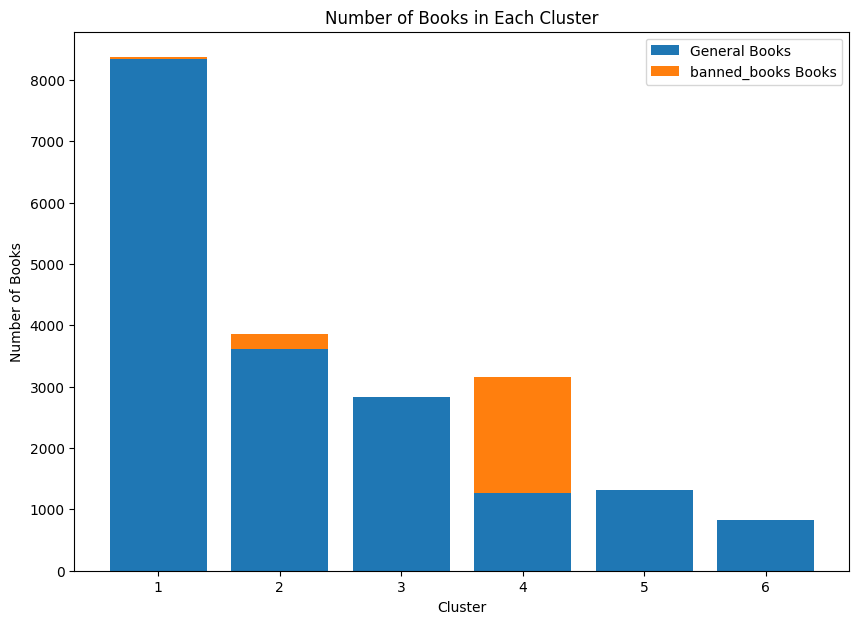

In [129]:
import matplotlib.pyplot as plt

# Count the number of books in each cluster for books starting with 'A'
counts_a = [len(cluster_numbers_A[cluster_numbers_A == i]) for i in range(6)]

# Count the number of books in each cluster for books starting with 'B'
counts_b = [len(cluster_numbers_B[cluster_numbers_B == i]) for i in range(6)]

# Cluster labels
clusters = range(1, 7)

# Plotting
plt.figure(figsize=(10, 7))
plt.bar(clusters, counts_a, label='General Books')
plt.bar(clusters, counts_b, bottom=counts_a, label='banned_books Books')
plt.xlabel('Cluster')
plt.ylabel('Number of Books')
plt.title('Number of Books in Each Cluster')
plt.xticks(clusters)
plt.legend()
plt.show()


In [130]:
df_A_reduced['labels'] = cluster_numbers_A
df_B_reduced['labels'] = cluster_numbers_B

df_with_labels = pd.concat([df_A_reduced,df_B_reduced])

df_with_labels

Component 1  Component 2  Component 3 book_id  labels
0       -0.360358     8.309109     3.735252      A1       1
1       -2.034178    -8.454108     2.399597      A2       2
2        0.404198     8.790272     1.856935      A3       1
3       -3.322836     6.929602    -2.103201      A4       1
4       -1.649510    -7.885747     2.250705      A5       2
...           ...          ...          ...     ...     ...
2157     0.974376     7.000155     2.421468   B2158       1
2158     1.448894    10.871700    11.346757   B2159       3
2159    12.241699     2.412134    15.442047   B2160       3
2160    13.238644     2.188606    14.099019   B2161       3
2161    13.253382     2.204421    14.160378   B2162       3

[20356 rows x 5 columns]

# Amazon Book Rating

In [131]:
df_rating=pd.read_csv("archive\\Books_rating.csv")

In [132]:
df_rating.head()

Id                           Title  Price         User_id  \
0  1882931173  Its Only Art If Its Well Hung!    NaN   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon    NaN  A30TK6U7DNS82R   
2  0826414346        Dr. Seuss: American Icon    NaN  A3UH4UZ4RSVO82   
3  0826414346        Dr. Seuss: American Icon    NaN  A2MVUWT453QH61   
4  0826414346        Dr. Seuss: American Icon    NaN  A22X4XUPKF66MR   

                          profileName review/helpfulness  review/score  \
0               Jim of Oz "jim-of-oz"                7/7           4.0   
1                       Kevin Killian              10/10           5.0   
2                        John Granger              10/11           5.0   
3  Roy E. Perry "amateur philosopher"                7/7           4.0   
4     D. H. Richards "ninthwavestore"                3/3           4.0   

   review/time                                   review/summary  \
0    940636800           Nice collection of Julie Strain images   
1   1095724800                                Really Enjoyed It   
2   1078790400  Essential for every personal and Public Library   
3   1090713600  Phlip Nel gives silly Seuss a serious treatment   
4   1107993600                           Good academic overview   

                                         review/text  
0  This is only for Julie Strain fans. It's a col...  
1  I don't care much for Dr. Seuss but after read...  
2  If people become the books they read and if "t...  
3  Theodore Seuss Geisel (1904-1991), aka &quot;D...  
4  Philip Nel - Dr. Seuss: American IconThis is b...

In [133]:
df_rating.drop(['Price', 'review/helpfulness', 'review/time', 'review/summary', 'review/text'], axis=1, inplace=True)

In [134]:
df_rating.head()

Id                           Title         User_id  \
0  1882931173  Its Only Art If Its Well Hung!   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon  A30TK6U7DNS82R   
2  0826414346        Dr. Seuss: American Icon  A3UH4UZ4RSVO82   
3  0826414346        Dr. Seuss: American Icon  A2MVUWT453QH61   
4  0826414346        Dr. Seuss: American Icon  A22X4XUPKF66MR   

                          profileName  review/score  
0               Jim of Oz "jim-of-oz"           4.0  
1                       Kevin Killian           5.0  
2                        John Granger           5.0  
3  Roy E. Perry "amateur philosopher"           4.0  
4     D. H. Richards "ninthwavestore"           4.0

In [135]:
# Check for NaN values in the DataFrame
print("Before dropping NaN values:")
print(df_rating.isna().sum())

# Drop rows with NaN values
df_rating = df_rating.dropna()

# Check again after dropping NaN values
print("\nAfter dropping NaN values:")
print(df_rating.isna().sum())


Before dropping NaN values:
Id                   0
Title              208
User_id         561787
profileName     561905
review/score         0
dtype: int64

After dropping NaN values:
Id              0
Title           0
User_id         0
profileName     0
review/score    0
dtype: int64


In [136]:
import re

def preprocess_text(text):
    # Remove extra white spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Convert text to lowercase
    text = text.lower()

    # Remove the string "a novel" without replacing it with a white space
    text = re.sub(r'\ba novel\b', '', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove extra white spaces again
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()


df_rating["Title"] = df_rating["Title"].apply(preprocess_text)

In [137]:
# Rename all column titles to lowercase
df_rating.columns = df_rating.columns.str.lower()
df_rating.rename(columns={'review/score':'rating'},inplace=True)

# Check the updated column titles
print("Updated Column Titles:")
print(df_rating.columns)

Updated Column Titles:
Index(['id', 'title', 'user_id', 'profilename', 'rating'], dtype='object')


In [138]:
# Merge the additional DataFrame with the existing DataFrame based on the "Title" column
user_rating_df = pd.merge(df_rating, filtered_amazon_books, on="title")


In [139]:
user_rating_df.head()

id                    title         user_id  \
0  0887402216  the battleship bismarck  A30IUAABSEHEPI   
1  0887402216  the battleship bismarck  A29SCEAL3JPMYW   
2  006000486X  tess and the highlander  A2VCGJLKGK2WJJ   
3  006000486X  tess and the highlander   AVWFMN5CELC8Q   
4  006000486X  tess and the highlander  A37XYM3KSEIDLS   

               profilename  rating  \
0         Lawrence Duckles     3.0   
1            Tim Grasshoff     4.0   
2           Rebecca Herman     5.0   
3                    sarah     4.0   
4  jaina_solo "jaina_solo"     5.0   

                                         description           authors  \
0  the bismarck is perhaps the most famous and no...  stefan draminski   
1  the bismarck is perhaps the most famous and no...  stefan draminski   
2  in 1543 on a windswept isle off of scotland se...    may mcgoldrick   
3  in 1543 on a windswept isle off of scotland se...    may mcgoldrick   
4  in 1543 on a windswept isle off of scotland se...    may mcgoldrick   

         categories book_id  
0           history      A1  
1           history      A1  
2  juvenile fiction      A2  
3  juvenile fiction      A2  
4  juvenile fiction      A2

In [140]:
# Check number of NaN values in the "book_id" column
num_na_book_id = user_rating_df['book_id'].isna().sum()

print("Number of NaN values in 'book_id':", num_na_book_id)


Number of NaN values in 'book_id': 0


In [141]:
user_rating_df.drop(["id",	"title", "profilename",	"description", "authors", "categories"], axis=1, inplace=True)

In [142]:
# Check for missing values
missing_values = user_rating_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 user_id    0
rating     0
book_id    0
dtype: int64


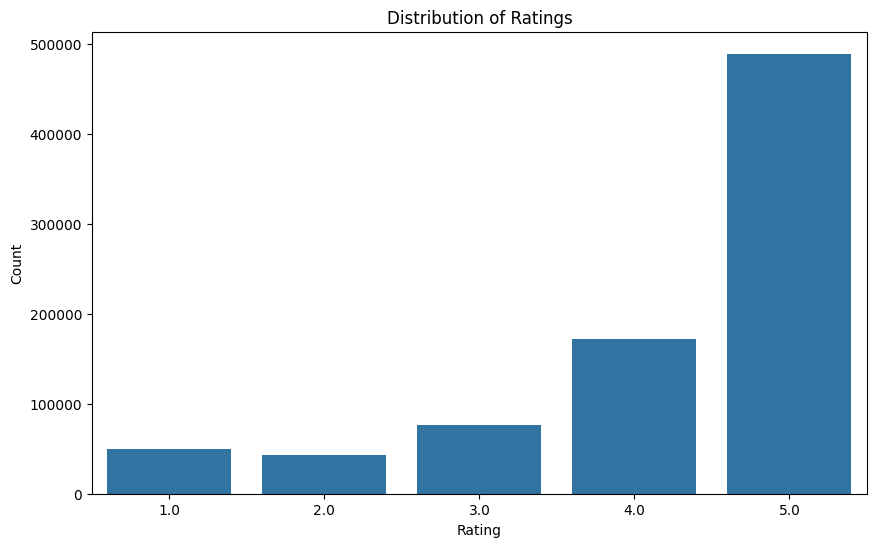

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.countplot(data=user_rating_df, x='rating')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [144]:
# Number of unique users
num_unique_users = user_rating_df['user_id'].nunique()
print("Number of unique users:", num_unique_users)


Number of unique users: 346322


In [145]:
# Number of unique books rated by users
num_unique_books = user_rating_df['book_id'].nunique()
print("Number of unique books rated by users:", num_unique_books)


Number of unique books rated by users: 17937


In [146]:
user_rating_df
(user_rating_df['book_id'].str.startswith('A')).sum()
(user_rating_df['book_id'].str.startswith('B')).sum()

0

In [147]:
user_rating_df

user_id  rating book_id
0       A30IUAABSEHEPI     3.0      A1
1       A29SCEAL3JPMYW     4.0      A1
2       A2VCGJLKGK2WJJ     5.0      A2
3        AVWFMN5CELC8Q     4.0      A2
4       A37XYM3KSEIDLS     5.0      A2
...                ...     ...     ...
829537  A2RAY8LD6V07A8     5.0  A11508
829538  A265RTGREAMEK7     5.0  A11508
829539  A1I5WK1AQ0OSH3     5.0  A11508
829540  A3CHUMF6LW6TSK     2.0  A11508
829541    AK536TCZST9B     2.0  A11508

[829542 rows x 3 columns]

In [148]:
df_with_labels

Component 1  Component 2  Component 3 book_id  labels
0       -0.360358     8.309109     3.735252      A1       1
1       -2.034178    -8.454108     2.399597      A2       2
2        0.404198     8.790272     1.856935      A3       1
3       -3.322836     6.929602    -2.103201      A4       1
4       -1.649510    -7.885747     2.250705      A5       2
...           ...          ...          ...     ...     ...
2157     0.974376     7.000155     2.421468   B2158       1
2158     1.448894    10.871700    11.346757   B2159       3
2159    12.241699     2.412134    15.442047   B2160       3
2160    13.238644     2.188606    14.099019   B2161       3
2161    13.253382     2.204421    14.160378   B2162       3

[20356 rows x 5 columns]

In [149]:
#user_rating_df.to_csv('D:\\AML project\\archive\\New Datasets\\ratings_data_preprocessed.csv')

In [150]:
#df_with_labels.to_csv('D:\\AML project\\archive\\New Datasets\\book_data_preprocessed.csv')